## About

In this notebook we prepare a simple solution for the [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

import pandas
import numpy

### Download data

In [3]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-06-21 13:42:31--  https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root
Resolving 2016.mlhep.yandex.net (2016.mlhep.yandex.net)... 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net (2016.mlhep.yandex.net)|2a02:6b8::1:208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 932820 (911K) [application/octet-stream]
Saving to: 'public_train_10000.root'

100%[======================================>] 932,820     4.43MB/s   in 0.2s   

2016-06-21 13:42:31 (4.43 MB/s) - 'public_train_10000.root' saved [932820/932820]



In [4]:
# you can download training sample with 100000 available events
# uncomment the below row
!cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-06-21 13:42:43--  https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root
Resolving 2016.mlhep.yandex.net (2016.mlhep.yandex.net)... 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net (2016.mlhep.yandex.net)|2a02:6b8::1:208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9245432 (8.8M) [application/octet-stream]
Saving to: 'public_train_100000.root'

100%[======================================>] 9,245,432   7.38MB/s   in 1.2s   

2016-06-21 13:42:44 (7.38 MB/s) - 'public_train_100000.root' saved [9245432/9245432]



In [5]:
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
--2016-06-21 13:42:48--  https://2016.mlhep.yandex.net/data/higgs/public_test.root
Resolving 2016.mlhep.yandex.net (2016.mlhep.yandex.net)... 2a02:6b8::1:208
Connecting to 2016.mlhep.yandex.net (2016.mlhep.yandex.net)|2a02:6b8::1:208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 91931408 (88M) [application/octet-stream]
Saving to: 'public_test.root'

100%[======================================>] 91,931,408  28.9MB/s   in 3.0s   

2016-06-21 13:42:51 (28.9 MB/s) - 'public_test.root' saved [91931408/91931408]



### Read the smallest part of training file and test file

In [6]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_100000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

### Define training features

Exclude `event_id`, `target` from the features set

In [9]:
features = list(set(data.columns) - {'event_id', 'target'})
features

['jet3_pt',
 'jet3_eta',
 'm_jjj',
 'mem_phi',
 'jet1_pt',
 'jet4_phi',
 'jet1_phi',
 'jet2_eta',
 'jet3_btag',
 'm_jlv',
 'm_wbb',
 'jet4_pt',
 'jet4_btag',
 'jet2_pt',
 'jet1_btag',
 'm_jj',
 'm_wwbb',
 'jet2_phi',
 'lepton_phi',
 'm_bb',
 'm_lv',
 'jet4_eta',
 'jet2_btag',
 'lepton_pt',
 'mem_pt',
 'lepton_eta',
 'jet3_phi',
 'jet1_eta']

### Prepare high-level features for training

In [10]:
high_level_features = ['m_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']

### Plot histograms for each high-level feature

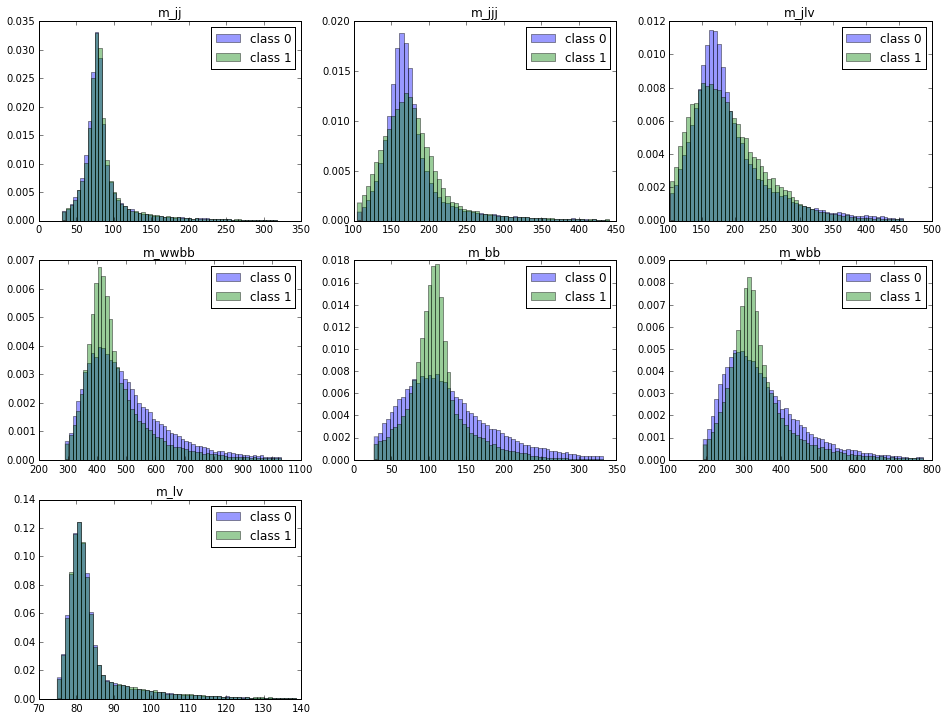

In [11]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(high_level_features):
    # add sub plot on our figure
    plt.subplot(len(features) // 5 + 1, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

In [18]:
from sklearn.ensemb import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

def get_validated_trained(data, features, part):
    training_data, validation_data = train_test_split(data, random_state=3747824, train_size=part)
    fitter = RandomForestClassifier(
        500,
        max_depth=17,
        n_jobs=-1,
        verbose=True,
    )
    fitter.fit(training_data[features], training_data.target)
    results = fitter.predict_proba(validation_data[features])
    print 'Validation:', roc_auc_score(validation_data.target, results[:, 1])
    return fitter

def get_full_trained(data, features):
    fitter = RandomForestClassifier(
        500,
        max_depth=17,
        n_jobs=-1,
        verbose=True,
    )
    fitter.fit(training_data[features], training_data.target)
    return fitter

def get_result(fitter, test, features):
    return fitter.predict_proba(test[features])

ImportError: No module named ensemblee

In [ ]:
fitter = get_validated_trained(data, high_level_features, 0.6)

## Prepare submission to kaggle

In [ ]:
# predict test sample
kaggle_proba = get_result(fitter, test, features)
kaggle_ids = test.event_id

In [ ]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)